# Predict time-series data using LSTM

In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


## Load and Normalize the Dataset 

In [2]:
numpy.random.seed(7)

dataframe = pandas.read_csv('rnn_data.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

In [3]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

## Data Preprocessing
### - divide data into training and test set
### - reshape data array

In [4]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print "train_data_size: "+str(len(train)), " test_data_size: "+str(len(test))

train_data_size: 11491  test_data_size: 5660


In [5]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [6]:
look_back = 14
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [7]:
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## Create and Fit the LSTM Network

In [8]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(None, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs = 2, batch_size = 1, verbose = 2)

Epoch 1/2
43s - loss: 0.0014
Epoch 2/2
42s - loss: 0.0014


## Prediction

In [9]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [10]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

## Calculate MSE
### - Compute average of MSE

In [11]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print(trainY[0])
print(trainPredict[:,0])
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print(testY[0])
print(testPredict[:,0])
print('Test Score: %.2f RMSE' % (testScore))

[ 0.  0.  0. ...,  1.  1.  6.]
[ 0.62594604  0.22282633  0.07694256 ...,  1.70778549  1.41440749
  1.69382823]
Train Score: 4.86 RMSE
[  2.           1.           1.         ...,  43.00000144  21.99999904
  14.99999952]
[  1.90415967   1.76343453   1.30459511 ...,  17.36426163  16.67621231
  17.28693962]
Test Score: 13.18 RMSE


## Plot of Results

In [12]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [13]:
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

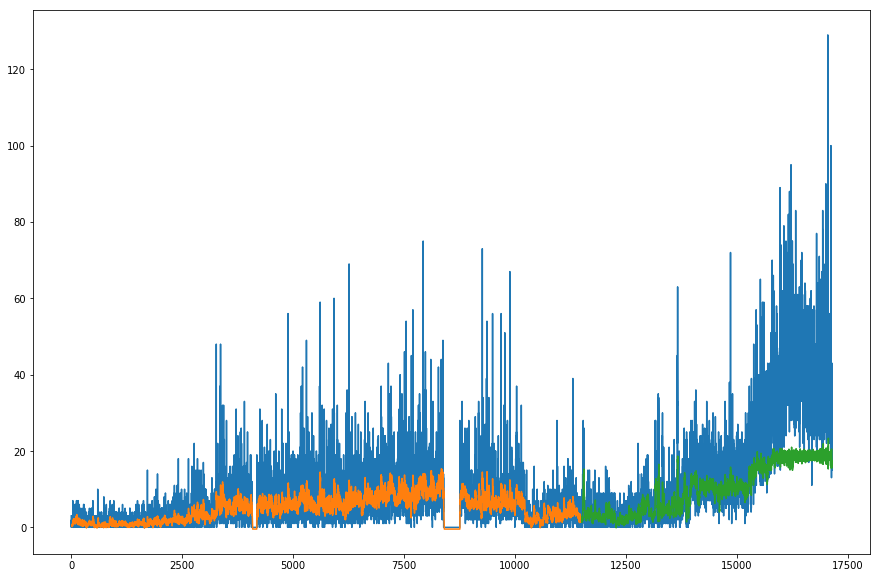

In [14]:
# plot baseline and predictions
plt.figure(figsize = (15, 10))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Discussion
### 기존의 neural network는 인풋의 순서나 지속성에 대해 고려하지 않기 때문에 시계열 데이터에 대해서는 좋지 않은 퍼포먼스를 내는데, 이러한 문제점을 해결한 것이 rnn이다. rnn은 그림에서처럼 시간 순의 여러 연속된 데이터들을 인풋으로 하여 다음 데이터를 예측하도록 합니다. 이번 프로젝트 데이터에 대해서는 many to one 모델을 적용하였다. 하지만 기존의 rnn에서는 최근의 데이터와 연관있는 데이터에서는 잘 동작하지만, 더 과거의 정보가 필요한 경우, 잘 동작하지 못한다는 단점이 있다. 즉, 단기적으로는 성능이 좋지만 장기적인 데이터에서는 성능이 좋지 않다는 것이다. 그래서 현재 가장 많이 사용되는 rnn인 lstm을 이용해 구현해보았다. lstm은 장기적으로 기억되는 데이터와 삭제해도 되는 데이터를 나누어 앞선 문제점을 해결한 모델을 말한다.
### 일별 테러 발생횟수와 월별 테러가 가장 많이 일어난 지역을 rnn을 통해 학습시켜보았다. 학습을 통해 어느 정도 경향을 따라가는 결과를 보였지만, 크게 증가하거나 크게 감소하는 데이터에 대해서는 잘 예측하지 못하는 것을 확인했다. 이는 데이터가 불규칙하고 양이 많기 때문에 더 많은 학습이 필요하며, 현재는 layer를 좀 더 늘린다면 에러가 많이 줄어들 것이다. 계산량이 매우 많기 때문에 학습시키는데 꽤 시간이 소요되고, 일반 컴퓨터로는 한계가 있기 때문에 더 좋은 환경에서 시도해보면 더 좋은 결과를 기대할 수 있을 것으로 보인다. 또한 테러 발생 주기는 테러리스트들의 심리와 밀접하게 관련되어있기 때문에 rnn내부의 마르코프 모델을 변형하는 것도 좋은 개선방안이 될 수 있을 것이다.